C:\Users\Adrian\AppData\Local\Temp\ipykernel_39700\2961283866.py:77: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.91, 0.98])  # leave room for cbar


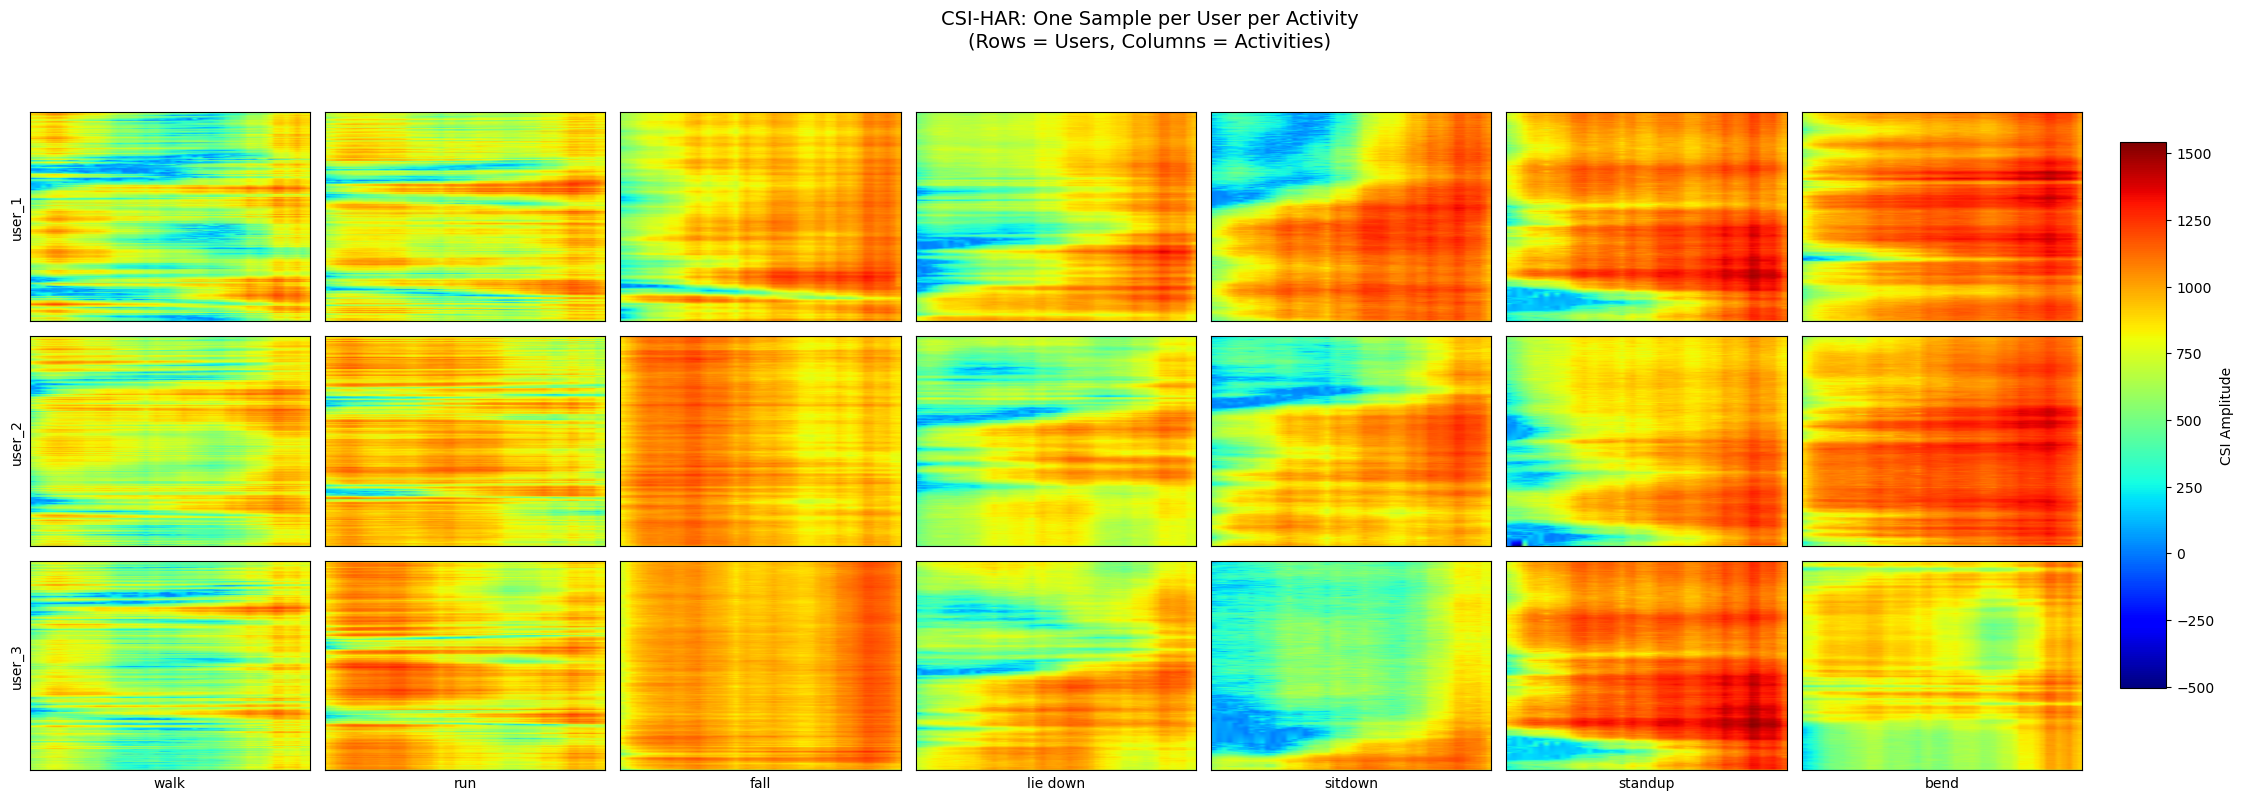

In [20]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re

DATASET_ROOT = r'F:/Datasets/CSI-HAR-Dataset-Raspberry-Pi-4/CSI-HAR-Dataset'  # update this!
ACTIVITIES = ['walk', 'run', 'fall', 'lie down', 'sitdown', 'standup', 'bend']
USERS = ['user_1', 'user_2', 'user_3']


# --- Collect one sample per user, per activity ---
samples_to_plot = {}
for user in USERS:
    samples_to_plot[user] = {}
    for activity in ACTIVITIES:
        folder = os.path.join(DATASET_ROOT, activity)
        files = [f for f in os.listdir(folder) if f.endswith('.csv') and not f.startswith('Annotation')]
        pattern = re.compile(rf'^{user}_sample_\d+_{activity}.*\.csv$')
        user_files = [f for f in files if pattern.match(f)]
        if user_files:
            chosen_file = user_files[0]
            samples_to_plot[user][activity] = os.path.join(folder, chosen_file)
        else:
            samples_to_plot[user][activity] = None

# --- Plotting ---
n_rows = len(USERS)
n_cols = len(ACTIVITIES)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(3.3*n_cols, 2.6*n_rows), squeeze=False)
plt.subplots_adjust(hspace=0.4, wspace=0.25, right=0.90)  # Leave space for colorbar

# We'll use the same vmin/vmax for all to keep the colorbar meaningful
all_data = []
for user in USERS:
    for activity in ACTIVITIES:
        file_path = samples_to_plot[user][activity]
        if file_path is not None:
            csi = pd.read_csv(file_path, header=None)
            csi = csi.apply(pd.to_numeric, errors='coerce').values
            csi = csi[~np.isnan(csi).all(axis=1)]
            csi = csi[:, ~np.isnan(csi).all(axis=0)]
            if csi.size > 0:
                all_data.append(csi)
vmin = min([np.nanmin(d) for d in all_data if d.size > 0])
vmax = max([np.nanmax(d) for d in all_data if d.size > 0])

for i, user in enumerate(USERS):
    for j, activity in enumerate(ACTIVITIES):
        ax = axes[i, j]
        file_path = samples_to_plot[user][activity]
        if file_path is not None:
            csi = pd.read_csv(file_path, header=None)
            csi = csi.apply(pd.to_numeric, errors='coerce').values
            csi = csi[~np.isnan(csi).all(axis=1)]
            csi = csi[:, ~np.isnan(csi).all(axis=0)]
            if csi.size == 0:
                ax.set_axis_off()
                ax.set_title("EMPTY", fontsize=9, color='red')
                continue
            im = ax.imshow(csi, aspect='auto', cmap='jet', origin='lower', vmin=vmin, vmax=vmax)
        else:
            ax.set_axis_off()
            ax.set_title("NOT FOUND", fontsize=9, color='red')
        ax.set_xticks([])
        ax.set_yticks([])
        if j == 0:
            ax.set_ylabel(user, fontsize=10)
        if i == n_rows - 1:
            ax.set_xlabel(activity, fontsize=10)

# Add shared colorbar on the right side
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
fig.colorbar(im, cax=cbar_ax, label='CSI Amplitude')

plt.suptitle("CSI-HAR: One Sample per User per Activity\n(Rows = Users, Columns = Activities)", fontsize=14, y=1.02)
plt.tight_layout(rect=[0, 0, 0.91, 0.98])  # leave room for cbar
plt.show()


C:\Users\Adrian\AppData\Local\Temp\ipykernel_39700\3655483536.py:99: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.91, 0.98])  # leave room for colorbar


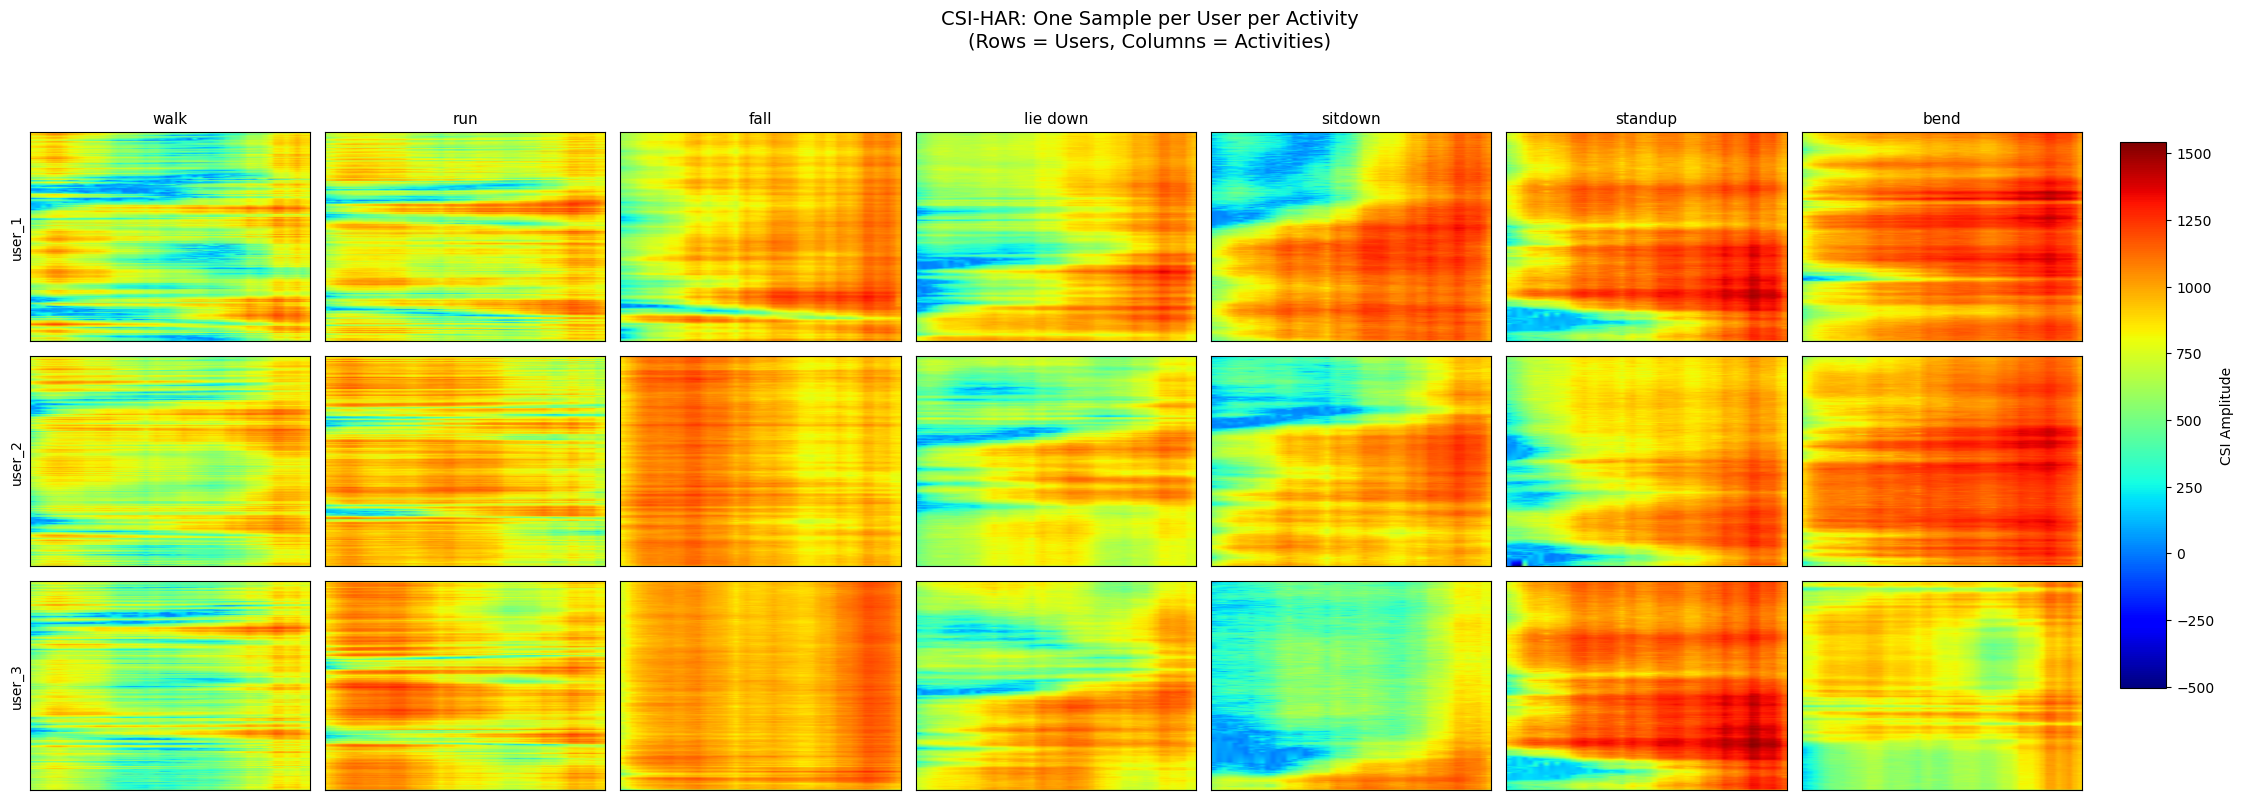

In [26]:
import os
import re
from pathlib import Path
from typing import Optional

import numpy as np
import pandas as pd

# Configuration
DATASET_ROOT = Path(r'F:/Datasets/CSI-HAR-Dataset-Raspberry-Pi-4/CSI-HAR-Dataset')  # adjust if needed
ACTIVITIES = ['walk', 'run', 'fall', 'lie down', 'sitdown', 'standup', 'bend']
USERS = ['user_1', 'user_2', 'user_3']
FILENAME_PATTERN = r'^{user}_sample_\d+_{activity}.*\.csv$'
OUTLIER_ZSCORE_THRESHOLD = 5.0  # tune as desired

def load_and_clean_csi(path: Path) -> Optional[np.ndarray]:
    try:
        df = pd.read_csv(path, header=None)
    except Exception as e:
        return None
    arr = df.apply(pd.to_numeric, errors='coerce').values
    arr = arr[~np.isnan(arr).all(axis=1)]
    arr = arr[:, ~np.isnan(arr).all(axis=0)]
    if arr.size == 0:
        return None
    return arr

def count_constant_axes(arr: np.ndarray, axis: int, atol: float = 1e-8) -> int:
    if axis == 1:
        diffs = np.ptp(arr, axis=1)
    else:
        diffs = np.ptp(arr, axis=0)
    return int(np.sum(diffs <= atol))

def compute_outlier_fraction(arr: np.ndarray, z_thresh: float) -> float:
    flat = arr.flatten()
    mean = np.nanmean(flat)
    std = np.nanstd(flat)
    if std == 0 or np.isnan(std):
        return 0.0
    z = (flat - mean) / std
    extreme = np.abs(z) > z_thresh
    return float(np.sum(extreme)) / flat.size

def inspect_all_files():
    records = []
    for user in USERS:
        for activity in ACTIVITIES:
            folder = DATASET_ROOT / activity
            if not folder.is_dir():
                print(f"[WARN] Missing activity folder: {folder}")
                continue
            try:
                all_files = [f for f in os.listdir(folder) if f.endswith('.csv') and not f.startswith('Annotation')]
            except Exception as e:
                print(f"[ERROR] Could not list '{folder}': {e}")
                continue
            pattern = re.compile(FILENAME_PATTERN.format(
                user=re.escape(user), activity=re.escape(activity)
            ))
            matched = sorted(f for f in all_files if pattern.match(f))
            for fname in matched:
                path = folder / fname
                cleaned = load_and_clean_csi(path)
                try:
                    raw_df = pd.read_csv(path, header=None)
                    raw_arr = raw_df.apply(pd.to_numeric, errors='coerce').values
                except Exception:
                    raw_arr = None

                row = {
                    "user": user,
                    "activity": activity,
                    "filename": fname,
                    "exists": True,
                    "error": None,
                    "original_shape": raw_arr.shape if raw_arr is not None else None,
                    "cleaned_shape": cleaned.shape if cleaned is not None else None,
                }

                target = cleaned if cleaned is not None else raw_arr
                if target is None:
                    row.update({
                        "n_nan": None,
                        "n_inf": None,
                        "all_zero": None,
                        "constant_rows": None,
                        "constant_cols": None,
                        "outlier_fraction": None,
                        "min": None,
                        "max": None,
                        "mean": None,
                        "std": None,
                        "problematic": True,
                    })
                else:
                    n_nan = int(np.isnan(target).sum())
                    n_inf = int(np.isinf(target).sum())
                    all_zero = bool(np.allclose(target, 0, atol=1e-12))
                    const_rows = count_constant_axes(target, axis=1)
                    const_cols = count_constant_axes(target, axis=0)
                    outlier_frac = compute_outlier_fraction(target, OUTLIER_ZSCORE_THRESHOLD)
                    flat = target.flatten()
                    finite = flat[np.isfinite(flat)]
                    stats = {
                        "n_nan": n_nan,
                        "n_inf": n_inf,
                        "all_zero": all_zero,
                        "constant_rows": const_rows,
                        "constant_cols": const_cols,
                        "outlier_fraction": outlier_frac,
                        "min": float(np.nanmin(target)) if finite.size > 0 else None,
                        "max": float(np.nanmax(target)) if finite.size > 0 else None,
                        "mean": float(np.nanmean(target)) if finite.size > 0 else None,
                        "std": float(np.nanstd(target)) if finite.size > 0 else None,
                    }
                    row.update(stats)
                    # heuristic
                    problematic = False
                    if n_nan > 0 or all_zero or const_rows > 0 or const_cols > 0 or outlier_frac > 0.05:
                        problematic = True
                    row["problematic"] = problematic

                records.append(row)

    df = pd.DataFrame.from_records(records)
    # reorder for readability
    cols = [
        "user", "activity", "filename", "exists", "error",
        "original_shape", "cleaned_shape", "n_nan", "n_inf", "all_zero",
        "constant_rows", "constant_cols", "outlier_fraction",
        "min", "max", "mean", "std", "problematic"
    ]
    df = df[[c for c in cols if c in df.columns]]
    return df

if __name__ == "__main__":
    df = inspect_all_files()
    print(f"Total files inspected: {len(df)}")
    print(f"Problematic count: {df['problematic'].sum()}")
    # Save for review
    df.to_csv("full_csi_quality_report.csv", index=False)
    # Example: show per user/activity file counts
    summary = df.groupby(["user", "activity"]).size().unstack(fill_value=0)
    print("Counts per user/activity:")
    print(summary)


Total files inspected: 420
Problematic count: 0
Counts per user/activity:
activity  bend  fall  lie down  run  sitdown  standup  walk
user                                                       
user_1      20    20        20   20       20       20    20
user_2      20    20        20   20       20       20    20
user_3      20    20        20   20       20       20    20


In [27]:
import os
import re
from pathlib import Path
from typing import Optional

import numpy as np
import pandas as pd

# === CONFIGURATION ===
DATASET_ROOT = Path(r'F:/Datasets/CSI-HAR-Dataset-Raspberry-Pi-4/CSI-HAR-Dataset')  # adjust as needed
ACTIVITIES = ['walk', 'run', 'fall', 'lie down', 'sitdown', 'standup', 'bend']
USERS = ['user_1', 'user_2', 'user_3']
FILENAME_PATTERN = r'^{user}_sample_\d+_{activity}.*\.csv$'
OUTLIER_ZSCORE_THRESHOLD = 5.0  # z-score beyond this considered extreme
OUTLIER_FRACTION_THRESHOLD = 0.05  # >5% extreme values flags outliers

# === HELPERS ===
def load_and_clean_csi(path: Path) -> Optional[np.ndarray]:
    try:
        df = pd.read_csv(path, header=None)
    except Exception:
        return None
    arr = df.apply(pd.to_numeric, errors='coerce').values
    arr = arr[~np.isnan(arr).all(axis=1)]
    arr = arr[:, ~np.isnan(arr).all(axis=0)]
    if arr.size == 0:
        return None
    return arr

def count_constant_axes(arr: np.ndarray, axis: int, atol: float = 1e-8) -> int:
    if axis == 1:
        diffs = np.ptp(arr, axis=1)
    else:
        diffs = np.ptp(arr, axis=0)
    return int(np.sum(diffs <= atol))

def compute_outlier_fraction(arr: np.ndarray, z_thresh: float) -> float:
    flat = arr.flatten()
    mean = np.nanmean(flat)
    std = np.nanstd(flat)
    if std == 0 or np.isnan(std):
        return 0.0
    z = (flat - mean) / std
    extreme = np.abs(z) > z_thresh
    return float(np.sum(extreme)) / flat.size

def derive_issue_tags(row: dict) -> list[str]:
    tags = []
    if not row.get("exists", True):
        if row.get("error"):
            tags.append(row["error"])
        else:
            tags.append("missing")
        return tags  # other metrics won't exist
    if row.get("n_nan", 0) > 0:
        tags.append(f"n_nan={row['n_nan']}")
    if row.get("n_inf", 0) > 0:
        tags.append(f"n_inf={row['n_inf']}")
    if row.get("all_zero", False):
        tags.append("all_zero")
    if row.get("constant_rows", 0) > 0:
        tags.append(f"const_rows={row['constant_rows']}")
    if row.get("constant_cols", 0) > 0:
        tags.append(f"const_cols={row['constant_cols']}")
    if row.get("outlier_fraction", 0) > OUTLIER_FRACTION_THRESHOLD:
        tags.append(f"outliers={row['outlier_fraction']:.3f}")
    # If none of the above but still marked problematic, mark as "other"
    if row.get("problematic", False) and not tags:
        tags.append("unknown_issue")
    return tags

# === CORE INSPECTION ===
def inspect_all_files():
    records = []
    for user in USERS:
        for activity in ACTIVITIES:
            folder = DATASET_ROOT / activity
            if not folder.is_dir():
                # Record missing folder as problematic
                records.append({
                    "user": user,
                    "activity": activity,
                    "filename": None,
                    "exists": False,
                    "error": f"Missing folder '{activity}'",
                    "original_shape": None,
                    "cleaned_shape": None,
                    "n_nan": None,
                    "n_inf": None,
                    "all_zero": None,
                    "constant_rows": None,
                    "constant_cols": None,
                    "outlier_fraction": None,
                    "min": None,
                    "max": None,
                    "mean": None,
                    "std": None,
                    "problematic": True,
                })
                continue

            try:
                all_files = [f for f in os.listdir(folder) if f.endswith('.csv') and not f.startswith('Annotation')]
            except Exception as e:
                records.append({
                    "user": user,
                    "activity": activity,
                    "filename": None,
                    "exists": False,
                    "error": f"Listdir failure: {e}",
                    "original_shape": None,
                    "cleaned_shape": None,
                    "n_nan": None,
                    "n_inf": None,
                    "all_zero": None,
                    "constant_rows": None,
                    "constant_cols": None,
                    "outlier_fraction": None,
                    "min": None,
                    "max": None,
                    "mean": None,
                    "std": None,
                    "problematic": True,
                })
                continue

            pattern = re.compile(FILENAME_PATTERN.format(
                user=re.escape(user), activity=re.escape(activity)
            ))
            matched = sorted(f for f in all_files if pattern.match(f))
            if not matched:
                records.append({
                    "user": user,
                    "activity": activity,
                    "filename": None,
                    "exists": False,
                    "error": "No matching file",
                    "original_shape": None,
                    "cleaned_shape": None,
                    "n_nan": None,
                    "n_inf": None,
                    "all_zero": None,
                    "constant_rows": None,
                    "constant_cols": None,
                    "outlier_fraction": None,
                    "min": None,
                    "max": None,
                    "mean": None,
                    "std": None,
                    "problematic": True,
                })
                continue

            for fname in matched:
                path = folder / fname
                cleaned = load_and_clean_csi(path)
                try:
                    raw_df = pd.read_csv(path, header=None)
                    raw_arr = raw_df.apply(pd.to_numeric, errors='coerce').values
                except Exception:
                    raw_arr = None

                row = {
                    "user": user,
                    "activity": activity,
                    "filename": fname,
                    "exists": True,
                    "error": None,
                    "original_shape": raw_arr.shape if raw_arr is not None else None,
                    "cleaned_shape": cleaned.shape if cleaned is not None else None,
                }

                target = cleaned if cleaned is not None else raw_arr
                if target is None:
                    row.update({
                        "n_nan": None,
                        "n_inf": None,
                        "all_zero": None,
                        "constant_rows": None,
                        "constant_cols": None,
                        "outlier_fraction": None,
                        "min": None,
                        "max": None,
                        "mean": None,
                        "std": None,
                        "problematic": True,
                    })
                else:
                    n_nan = int(np.isnan(target).sum())
                    n_inf = int(np.isinf(target).sum())
                    all_zero = bool(np.allclose(target, 0, atol=1e-12))
                    const_rows = count_constant_axes(target, axis=1)
                    const_cols = count_constant_axes(target, axis=0)
                    outlier_frac = compute_outlier_fraction(target, OUTLIER_ZSCORE_THRESHOLD)
                    flat = target.flatten()
                    finite = flat[np.isfinite(flat)]
                    stats = {
                        "n_nan": n_nan,
                        "n_inf": n_inf,
                        "all_zero": all_zero,
                        "constant_rows": const_rows,
                        "constant_cols": const_cols,
                        "outlier_fraction": outlier_frac,
                        "min": float(np.nanmin(target)) if finite.size > 0 else None,
                        "max": float(np.nanmax(target)) if finite.size > 0 else None,
                        "mean": float(np.nanmean(target)) if finite.size > 0 else None,
                        "std": float(np.nanstd(target)) if finite.size > 0 else None,
                    }
                    row.update(stats)
                    problematic = False
                    if n_nan > 0 or all_zero or const_rows > 0 or const_cols > 0 or outlier_frac > OUTLIER_FRACTION_THRESHOLD:
                        problematic = True
                    row["problematic"] = problematic

                records.append(row)

    df = pd.DataFrame.from_records(records)
    return df

# === SUMMARY PRINTING ===
def print_problematic_summary(df: pd.DataFrame):
    # Filter only problematic rows
    prob = df[df["problematic"] == True].copy()
    if prob.empty:
        print("✅ No problematic samples detected.")
        return

    total_inspected = len(df)
    total_problematic = len(prob)
    print(f"\n=== Dataset Quality Summary ===")
    print(f"Total files/combinations inspected: {total_inspected}")
    print(f"Problematic entries: {total_problematic} ({total_problematic/total_inspected:.1%})\n")

    # Derive issue tags for each problematic row
    prob["issue_tags"] = prob.apply(lambda r: derive_issue_tags(r.to_dict()), axis=1)

    # Flatten tag counts
    tag_counter: dict[str, int] = {}
    for tags in prob["issue_tags"]:
        for t in tags:
            tag_counter[t] = tag_counter.get(t, 0) + 1
    print("Issue breakdown (tag : count):")
    for tag, cnt in sorted(tag_counter.items(), key=lambda x: -x[1]):
        print(f"  {tag:20s} {cnt}")

    # Per user/activity aggregation
    group = prob.groupby(["user", "activity"]).size().sort_values(ascending=False)
    print("\nProblematic counts per (user, activity):")
    for (user, activity), cnt in group.items():
        print(f"  {user:8s} / {activity:10s} : {cnt}")

    # Show worst offenders: by number of distinct issue tags, then outlier fraction, then NaNs
    def severity_score(row):
        tags = derive_issue_tags(row.to_dict())
        score = len(tags) * 10
        outlier = row.get("outlier_fraction") or 0
        score += int(outlier * 100)
        score += (row.get("n_nan") or 0)
        return score

    prob["severity"] = prob.apply(severity_score, axis=1)
    worst = prob.sort_values(by="severity", ascending=False).head(20)

    print("\nTop problematic samples (worst first):")
    for _, row in worst.iterrows():
        tags = ", ".join(row["issue_tags"])
        print(
            f" - {row['user']:8s} / {row['activity']:10s} / {row['filename']:30s} "
            f"issues=[{tags}] "
            f"shapes=orig{row['original_shape']} clean{row['cleaned_shape']} "
            f"outlier_frac={row.get('outlier_fraction'):.4f} n_nan={row.get('n_nan')} n_inf={row.get('n_inf')}"
        )

    # Optional: small breakdown of types of problems (e.g., how many all_zero vs missing)
    special = prob[prob["all_zero"] == True]
    if not special.empty:
        print(f"\nAll-zero arrays: {len(special)} samples.")

    missing = prob[~prob["exists"]]
    if not missing.empty:
        print(f"Missing / unreadable combos: {len(missing)} entries.")

if __name__ == "__main__":
    df = inspect_all_files()
    print_problematic_summary(df)


✅ No problematic samples detected.


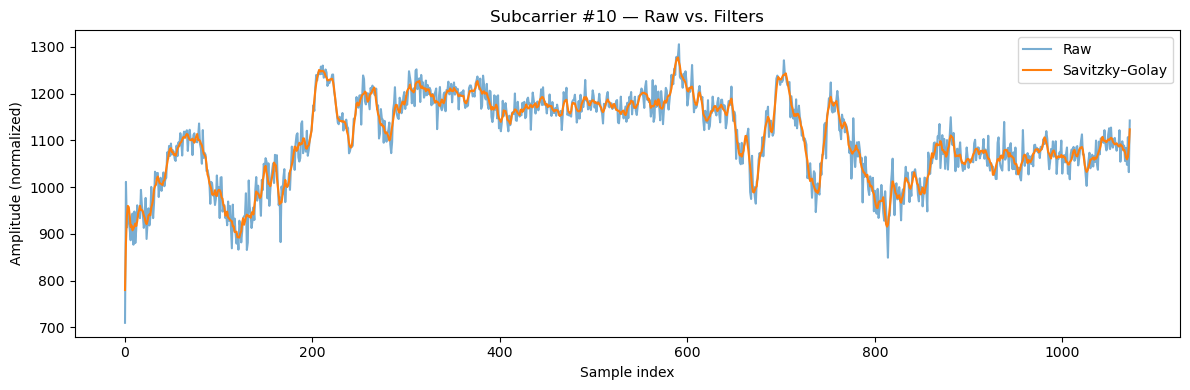

In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
import pywt

# === Filter functions ===

def hampel_filter_1d(x, window_size=11, n_sigmas=3):
    # Force odd window size
    if window_size % 2 == 0:
        window_size += 1
    k = (window_size - 1) // 2
    x_filtered = x.copy()
    n = len(x)
    for i in range(n):
        start = max(0, i - k)
        end = min(n, i + k + 1)
        window = x[start:end]
        med = np.median(window)
        mad = np.median(np.abs(window - med))
        threshold = n_sigmas * 1.4826 * mad
        if np.abs(x[i] - med) > threshold:
            x_filtered[i] = med
    return x_filtered

def wavelet_denoise_1d(x, wavelet='sym6', level=5, mode='symmetric', thresh_method='soft'):
    coeffs = pywt.wavedec(x, wavelet=wavelet, level=level, mode=mode)
    # noise sigma estimate from first detail
    sigma = np.median(np.abs(coeffs[-1])) / 0.6745
    uthresh = sigma * np.sqrt(2*np.log(len(x)))
    new_coeffs = [coeffs[0]] + [
        pywt.threshold(c, uthresh, mode=thresh_method) for c in coeffs[1:]
    ]
    x_denoised = pywt.waverec(new_coeffs, wavelet=wavelet, mode=mode)
    # trim or pad to original length
    if len(x_denoised) > len(x):
        x_denoised = x_denoised[:len(x)]
    elif len(x_denoised) < len(x):
        x_denoised = np.pad(x_denoised, (0, len(x)-len(x_denoised)), mode='edge')
    return x_denoised

# === Load and process one file / subcarrier ===

file_path   = "F:/Datasets/CSI-HAR-Dataset-Raspberry-Pi-4/CSI-HAR-Dataset/bend/user_1_sample_1_bend_A.csv"  # ← update this
subcarrier_idx = 10                     # ← choose 0–51

# read raw CSI data (no header assumed)
df = pd.read_csv(file_path, header=None)
signal = df.iloc[:, subcarrier_idx].dropna().values

# apply filters
savgol     = savgol_filter(signal, window_length=11, polyorder=3)
hampel     = hampel_filter_1d(signal, window_size=11, n_sigmas=3)
wavelet    = wavelet_denoise_1d(signal, wavelet='sym6', level=5)

# === Plotting ===

plt.figure(figsize=(12, 4))
plt.plot(signal,    label='Raw',           alpha=0.6)
plt.plot(savgol,    label='Savitzky–Golay')
#plt.plot(hampel,    label='Hampel filter')
#plt.plot(wavelet,   label='Wavelet denoise')
plt.title(f"Subcarrier #{subcarrier_idx} — Raw vs. Filters")
plt.xlabel("Sample index")
plt.ylabel("Amplitude (normalized)")
plt.legend(loc='best')
plt.tight_layout()
plt.show()


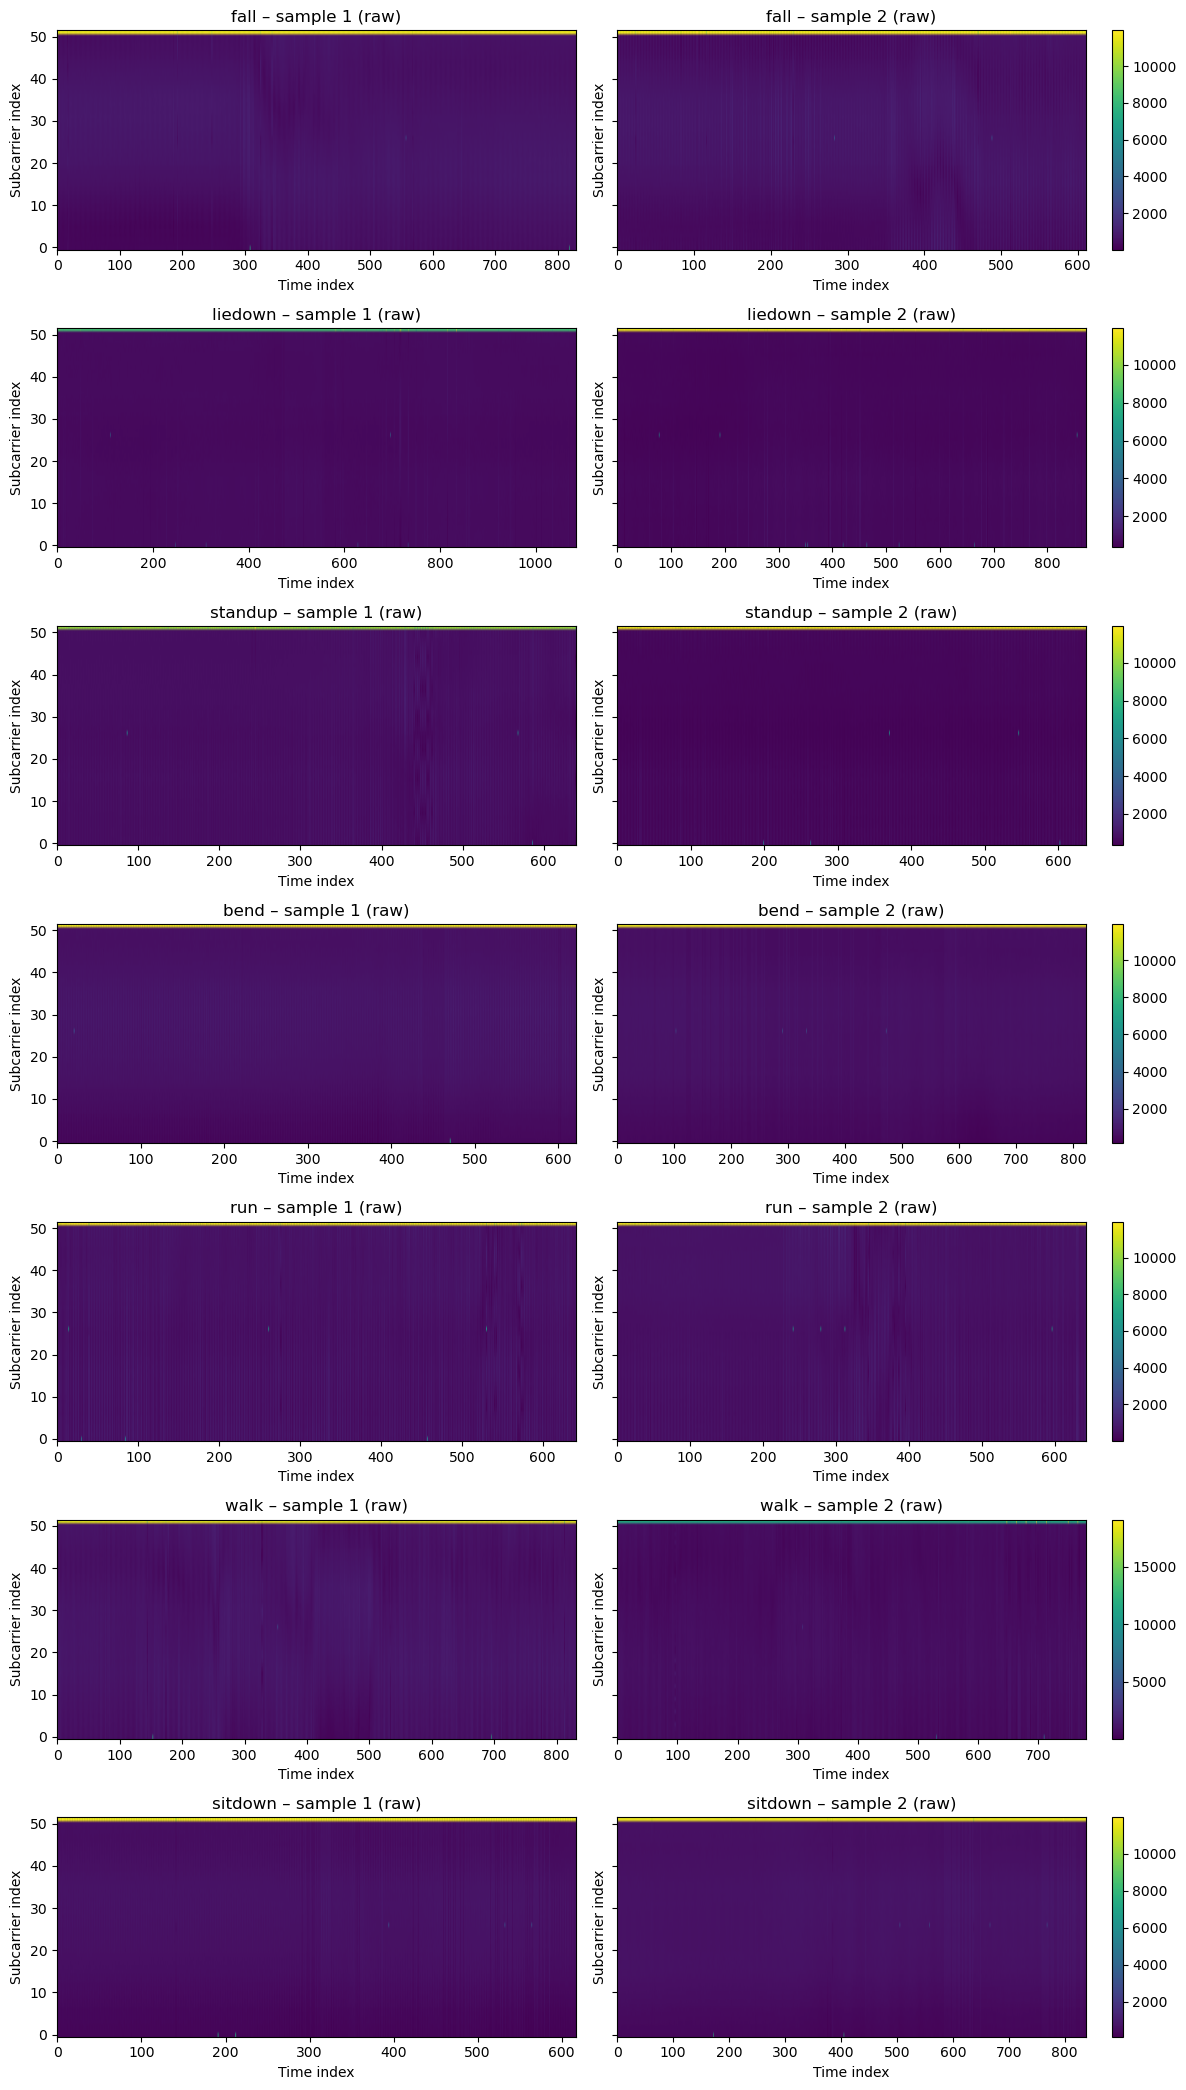

In [35]:
import random
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ─── CONFIG ───────────────────────────────────────────────────────────────────
DATA_ROOT  = r'F:/Datasets/MY_DATASET_NEW/csi_processed'
ACTIVITIES = ['fall','liedown','standup','bend','run','walk','sitdown']

# ─── PICK TWO FILES PER ACTIVITY ───────────────────────────────────────────────
files_per_act = {}
for act in ACTIVITIES:
    folder = os.path.join(DATA_ROOT, act)
    if not os.path.isdir(folder):
        continue
    csvs = [
        os.path.join(folder, fn)
        for fn in os.listdir(folder)
        if fn.lower().endswith('.csv')
    ]
    # randomly sample two if available
    files_per_act[act] = random.sample(csvs, 2) if len(csvs) >= 2 else csvs

# ─── PLOT RAW CSI TRACES ───────────────────────────────────────────────────────
n_act = len(ACTIVITIES)
fig, axes = plt.subplots(n_act, 2, figsize=(12, 3*n_act), sharex=False, sharey=True)

for i, act in enumerate(ACTIVITIES):
    for j, fp in enumerate(files_per_act.get(act, [])):
        # 1) load full raw CSI (no normalization)
        arr = pd.read_csv(fp, header=None).values
        # drop any all-NaN rows/columns
        arr = arr[~np.isnan(arr).all(axis=1)]
        arr = arr[:, ~np.isnan(arr).all(axis=0)]
        # 2) plot as heatmap: subcarrier idx (rows) vs time (columns)
        im = axes[i, j].imshow(arr.T, aspect='auto', origin='lower')
        axes[i, j].set_title(f"{act} – sample {j+1} (raw)")
        axes[i, j].set_ylabel("Subcarrier index")
        axes[i, j].set_xlabel("Time index")
        if j == 1:
            fig.colorbar(im, ax=axes[i, j], orientation='vertical', fraction=0.046)
    # if fewer than 2 samples, hide empty subplot
    if len(files_per_act.get(act, [])) < 2:
        axes[i, 1].axis('off')

plt.tight_layout()
plt.show()
